<a href="https://colab.research.google.com/github/qnrua0511/bikeseoul/blob/main/analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

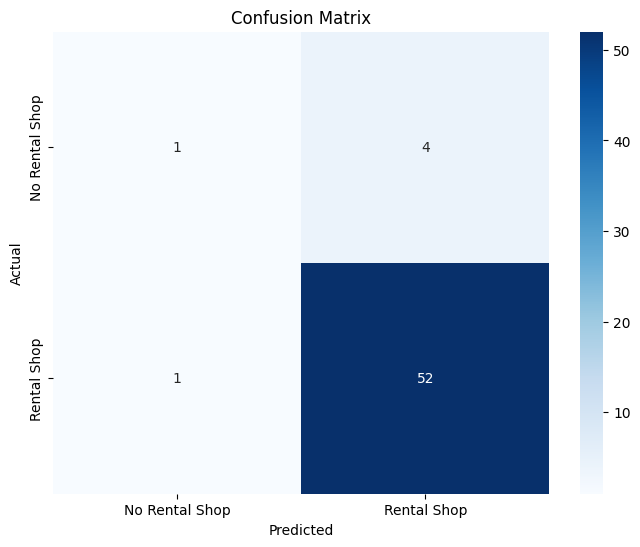

                precision    recall  f1-score   support

No Rental Shop       0.50      0.20      0.29         5
   Rental Shop       0.93      0.98      0.95        53

      accuracy                           0.91        58
     macro avg       0.71      0.59      0.62        58
  weighted avg       0.89      0.91      0.90        58



In [ ]:
import pandas as pd
from geopy.distance import geodesic
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
import seaborn as sns
import matplotlib.pyplot as plt

# 파일 불러오기
subway_df = pd.read_csv('subway.csv')
rental_shop_df = pd.read_csv('rental_shop_add.csv', encoding='cp949')

# 필요한 칼럼만 선택
subway_df = subway_df[['역명', '위도', '경도']]
rental_shop_df = rental_shop_df[['대여소명', '위도', '경도']]

# 결측치 제거
subway_df.dropna(inplace=True)
rental_shop_df.dropna(inplace=True)

# 지하철역 근처에 대여소가 있는지 여부 판단 함수
def is_nearby(subway_lat, subway_lon, rental_lat, rental_lon, threshold=0.5):
    distance = geodesic((subway_lat, subway_lon), (rental_lat, rental_lon)).km
    return distance <= threshold

# 각 지하철역에 대해 근처에 대여소가 있는지 여부를 판단하여 새로운 칼럼 추가
subway_df['대여소_근처'] = subway_df.apply(
    lambda row: any(is_nearby(row['위도'], row['경도'], r_lat, r_lon) for r_lat, r_lon in zip(rental_shop_df['위도'], rental_shop_df['경도'])),
    axis=1
)

# 특성(X)과 라벨(y) 정의
X = subway_df[['위도', '경도']]
y = subway_df['대여소_근처'].astype(int)

# 학습 데이터와 테스트 데이터 분할
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# 랜덤 포레스트 분류기 정의 및 학습
rf = RandomForestClassifier(random_state=42)
rf.fit(X_train, y_train)

# 예측
y_pred = rf.predict(X_test)
# 혼동행렬 계산
conf_matrix = confusion_matrix(y_test, y_pred)

# 혼동행렬 시각화
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=['No Rental Shop', 'Rental Shop'], yticklabels=['No Rental Shop', 'Rental Shop'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

# 분류 보고서 출력
print(classification_report(y_test, y_pred, target_names=['No Rental Shop', 'Rental Shop']))

랜덤 포레스트 분류

- 랜덤 포레스트가 조정을 안해도 어느 정도 성능이 좋게 나오기에 랜덤 포레스트 분류 사용

해석

- Rental Shop의 정밀도가 0.93으로 잘 예측함

- 하지만, No Rental Shop의 경우 데이터의 수가 적어 잘 예측하지 못함

- 데이터의 수가 적다는 것은 대부분의 지하철 역에는 대여소가 있기 때문임

=> 이를 통해 지하철역 근처에는 대여소가 대부분 있다는 것을 확인 할 수 있음



거리를 이용하여 다중 선형 회귀분석 가정
- 종속 변수: 이용건수
- 독립 변수: 지하철역, 대학교, 고등학교 각각의 좌표를 이용해 일정 거리 안에 대여소가 있는지를 이용

=> 데이터 불균형으로 적합하지 않다고 판단

종속변수를 대여소수로 하고, 각 독립변수(이용건수, 대학교 수, 고등학교 수, 인구밀도)가 어떠한 영향을 끼치는지 확인해보기

In [1]:
import pandas as pd
usage_12=pd.read_csv('usage_12.csv')
usage_12.head()

,대여년월,대여소번호,대여소명,대여구분코드,연령대코드,이용건수,운동량,탄소량,이용거리(M),이용시간(분),자치구
0,202312,102,망원역 1번출구 앞,일일권,20대,38,2338.03,23.61,101761.54,1414,마포구
1,202312,102,망원역 1번출구 앞,일일권,30대,20,1272.34,10.82,51448.03,490,마포구
2,202312,102,망원역 1번출구 앞,일일권,40대,3,149.55,1.39,5993.29,42,마포구
3,202312,102,망원역 1번출구 앞,일일권,60대,1,121.97,1.62,7000.00,51,마포구
4,202312,102,망원역 1번출구 앞,일일권,~10대,1,44.26,0.48,2070.00,16,마포구


In [2]:
usage_sum=usage_12.groupby('자치구')['이용건수'].sum().reset_index(name='이용건수')
usage_sum

,자치구,이용건수
0,강남구,63129
1,강동구,87333
2,강북구,30978
3,강서구,272404
4,관악구,48019
5,광진구,101353
6,구로구,85072
7,금천구,38275
8,노원구,133657
9,도봉구,45997


In [3]:
rental_shop_add=pd.read_csv('rental_shop_add.csv',encoding='cp949')
rental_shop_add.head()

,대여소번호,대여소명,자치구,상세주소,위도,경도
0,301,경복궁역 7번출구 앞,종로구,서울특별시 종로구 사직로 지하130 경복궁역 7번출구 앞,37.575794,126.971451
1,302,경복궁역 4번출구 뒤,종로구,서울특별시 종로구 사직로 지하130 경복궁역 4번출구 뒤,37.575947,126.974060
2,303,광화문역 1번출구 앞,종로구,서울특별시 종로구 세종대로 지하189 세종로공원,37.571770,126.974663
3,305,종로구청 옆,종로구,서울특별시 종로구 세종로 84-1,37.572559,126.978332
4,307,서울역사박물관 앞,종로구,서울특별시 종로구 새문안로 55 서울역사박물관 앞,37.570000,126.971100


In [4]:
rental_count=rental_shop_add.groupby('자치구').size().reset_index(name='대여소수')
rental_count

,자치구,대여소수
0,강남구,175
1,강동구,120
2,강북구,60
3,강서구,192
4,관악구,77
5,광진구,84
6,구로구,115
7,금천구,75
8,노원구,143
9,도봉구,76


In [5]:
data = pd.merge(usage_sum, rental_count, on='자치구')

In [6]:
from sklearn.linear_model import LinearRegression
X = data[['이용건수']]
y = data['대여소수']

# 선형 회귀 모델 생성 및 학습
model = LinearRegression()
model.fit(X, y)

# 회귀 계수와 절편 출력
print(f'회귀 계수: {model.coef_[0]}')
print(f'절편: {model.intercept_}')

# 모델 평가 (결정 계수 R^2)
r_squared = model.score(X, y)
print(f'결정 계수 R^2: {r_squared}')

회귀 계수: 0.0005507063163052319
절편: 64.13086024429747
결정 계수 R^2: 0.5924581596715117


In [7]:
subway=pd.read_csv('subway.csv')
subway.head()

,Unnamed: 0,연번,역번호,호선,역명,역전화번호,도로명주소,지번주소,위도,경도,자치구
0,0,1,150,1,서울,02-6110-1331,서울특별시 중구 세종대로 지하2(남대문로 5가),서울특별시 중구 남대문로5가 73-6 서울역(1호선),37.557159,126.972555,중구
1,1,2,151,1,시청,02-6110-1321,서울특별시 중구 세종대로 지하101(정동),서울특별시 중구 정동 5-5 시청역(1호선),37.565439,126.976983,중구
2,2,3,152,1,종각,02-6110-1311,서울특별시 종로구 종로 지하55(종로1가),서울특별시 종로구 종로1가 54 종각역(1호선),37.570214,126.983240,종로구
3,3,4,153,1,종로3가,02-6110-1301,서울특별시 종로구 종로 지하129(종로3가),서울특별시 종로구 종로3가 10-5 종로3가역(1호선),37.570427,126.992029,종로구
4,4,5,154,1,종로5가,02-6110-1291,서울특별시 종로구 종로 지하216(종로5가),서울특별시 종로구 종로5가 82-1 종로5가역(1호선),37.570908,127.001917,종로구


In [8]:
subway_count=subway.groupby('자치구').size().reset_index(name='지하철역수')
subway_count

,자치구,지하철역수
0,강남구,21
1,강동구,14
2,강북구,3
3,강서구,9
4,고양시,1
5,관악구,4
6,광명시,2
7,광진구,11
8,구로구,7
9,금천구,1


In [9]:
# 독립 변수(X)와 종속 변수(y) 설정
data = pd.merge(data, subway_count, on='자치구', how='left')
X = data[['이용건수', '지하철역수']]
y = data['대여소수']

# 선형 회귀 모델 생성 및 학습
model = LinearRegression()
model.fit(X, y)

# 회귀 계수와 절편 출력
coefficients = dict(zip(X.columns, model.coef_))
print(f'회귀 계수: {coefficients}')
print(f'절편: {model.intercept_}')

# 모델 평가 (결정 계수 R^2)
r_squared = model.score(X, y)
print(f'결정 계수 R^2: {r_squared}')

회귀 계수: {'이용건수': 0.00047081419029132334, '지하철역수': 2.648297757555307}
절편: 41.93541612487219
결정 계수 R^2: 0.7605075164750689


In [10]:
university_add=pd.read_csv('university_add.csv')
university_add.head()

,Unnamed: 0,학교종류,학교명,본분교,학교상태,설립,주소,위도,경도,자치구
0,0,일반대학,서울시립대학교,본교,기존,공립,서울 동대문구 서울시립대로 163 (전농동 90번지),37.582578,127.059988,동대문구
1,1,전문대학(3년제),서울여자간호대학교,본교,기존,사립,서울 서대문구 홍제3동 서울여자간호대학,37.597030,126.956477,서대문구
2,2,일반대학,서울여자대학교,본교,기존,사립,서울특별시 노원구 화랑로 621 서울여자대학교,37.627382,127.091621,노원구
3,3,전문대학(2년제),서일대학교,본교,학교명 변경,사립,서울특별시 중랑구 용마산로 90길 28 서일대학교,37.586083,127.097203,중랑구
4,4,일반대학,성공회대학교,본교,기존,사립,서울특별시 구로구 연동로 320 성공회대학교,37.487524,126.826164,구로구


In [11]:
university_count=university_add.groupby('자치구').size().reset_index(name='대학수')
university_count

,자치구,대학수
0,강남구,1
1,강북구,1
2,강서구,2
3,관악구,1
4,광진구,3
5,구로구,3
6,노원구,7
7,도봉구,1
8,동대문구,5
9,동작구,3


In [12]:
# 독립 변수(X)와 종속 변수(y) 설정
data = pd.merge(data, university_count, on='자치구', how='left')
data=data.fillna(0)

X = data[['이용건수', '지하철역수','대학수']]
y = data['대여소수']

# 선형 회귀 모델 생성 및 학습
model = LinearRegression()
model.fit(X, y)

# 회귀 계수와 절편 출력
coefficients = dict(zip(X.columns, model.coef_))
print(f'회귀 계수: {coefficients}')
print(f'절편: {model.intercept_}')

# 모델 평가 (결정 계수 R^2)
r_squared = model.score(X, y)
print(f'결정 계수 R^2: {r_squared}')

회귀 계수: {'이용건수': 0.00046320518013203267, '지하철역수': 2.6343267962957593, '대학수': -1.1793813007737146}
절편: 45.747592882564334
결정 계수 R^2: 0.7659130760562003


대학 수에 따라 감소한다는 것에 의문이 들어 변수가 유의한지 확인

In [13]:
import statsmodels.api as sm

# 종속 변수(y)와 독립 변수(X) 설정
X = data[['이용건수', '지하철역수', '대학수']]
y = data['대여소수']

# 상수항 추가 (절편을 모델에 포함시키기 위해)
X = sm.add_constant(X)

# OLS 모델 적합
model = sm.OLS(y, X).fit()

# 회귀 분석 결과 요약
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:                   대여소수   R-squared:                       0.766
Model:                            OLS   Adj. R-squared:                  0.732
Method:                 Least Squares   F-statistic:                     22.90
Date:                Mon, 26 Aug 2024   Prob (F-statistic):           8.02e-07
Time:                        07:24:58   Log-Likelihood:                -109.30
No. Observations:                  25   AIC:                             226.6
Df Residuals:                      21   BIC:                             231.5
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         45.7476     10.980      4.166      0.0

대학수의 p값이 0.494가 나온걸 보아 유의하지 않고, 이용건수와 지하철역수는 유의미한 변수인 것을 확인할 수 있다

대학수 변수는 유의하지 않으므로 제거

In [14]:
highschool_add=pd.read_csv('highschool_add.csv')
highschool_add.head()

,Unnamed: 0,학교종류명,설립구분,표준학교코드,학교명,영문학교명,관할조직명,도로명우편번호,도로명주소,위도,경도,자치구
0,0,고등학교,사립,7011569,미림마이스터고등학교,Mirim Meister High School,서울특별시교육청,8821,서울특별시 관악구 호암로 546,37.466102,126.931928,관악구
1,1,고등학교,사립,7011568,염광메디텍고등학교,Yumkwang Meditech High School,서울특별시교육청,1874,서울특별시 노원구 월계로45가길 9,37.630284,127.049265,노원구
2,2,고등학교,공립,7011558,서울웹툰애니메이션고등학교,Seoul Webtoon Animation High School,서울특별시교육청,6761,서울특별시 서초구 과천대로 852-23,37.469491,126.988246,서초구
3,3,고등학교,공립,7011540,솔샘고등학교,Solsaem High School,서울특별시교육청,1190,서울특별시 강북구 인수봉로 39,37.623765,127.012069,강북구
4,4,고등학교,사립,7011539,서울동구고등학교,SEOUL DONGGOO HIGH SCHOOL,서울특별시교육청,2834,서울특별시 성북구 성북로8길 71,37.594107,127.008216,성북구


In [15]:
highschool_count=highschool_add.groupby('자치구').size().reset_index(name='고등학교수')
highschool_count

,자치구,고등학교수
0,강남구,22
1,강동구,14
2,강북구,7
3,강서구,23
4,관악구,17
5,광진구,9
6,구로구,14
7,금천구,6
8,노원구,25
9,도봉구,9


In [16]:
# 독립 변수(X)와 종속 변수(y) 설정
data = pd.merge(data, highschool_count, on='자치구', how='left')
data=data.fillna(0)

X = data[['이용건수', '지하철역수','고등학교수']]
y = data['대여소수']

# 선형 회귀 모델 생성 및 학습
model = LinearRegression()
model.fit(X, y)

# 회귀 계수와 절편 출력
coefficients = dict(zip(X.columns, model.coef_))
print(f'회귀 계수: {coefficients}')
print(f'절편: {model.intercept_}')

# 모델 평가 (결정 계수 R^2)
r_squared = model.score(X, y)
print(f'결정 계수 R^2: {r_squared}')

회귀 계수: {'이용건수': 0.00039079449969617964, '지하철역수': 2.2597623919916363, '고등학교수': 1.7851155527672178}
절편: 30.20625610676278
결정 계수 R^2: 0.797875225278253


In [17]:
import statsmodels.api as sm

# 종속 변수(y)와 독립 변수(X) 설정
X = data[['이용건수', '지하철역수', '고등학교수']]
y = data['대여소수']

# 상수항 추가 (절편을 모델에 포함시키기 위해)
X = sm.add_constant(X)

# OLS 모델 적합
model = sm.OLS(y, X).fit()

# 회귀 분석 결과 요약
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:                   대여소수   R-squared:                       0.798
Model:                            OLS   Adj. R-squared:                  0.769
Method:                 Least Squares   F-statistic:                     27.63
Date:                Mon, 26 Aug 2024   Prob (F-statistic):           1.75e-07
Time:                        07:24:59   Log-Likelihood:                -107.47
No. Observations:                  25   AIC:                             222.9
Df Residuals:                      21   BIC:                             227.8
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         30.2063     10.661      2.833      0.0

인구수 변수 추가

In [26]:
population=pd.read_csv('population.csv')
population.head()

,Unnamed: 0,소계,종로구,중구,용산구,성동구,광진구,동대문구,중랑구,성북구,...,강서구,구로구,금천구,영등포구,동작구,관악구,서초구,강남구,송파구,강동구
0,0,9638799.0,150453.00,131793.00,227106.00,284766.00,351180.00,359873.00,387470.0,438168.00,...,568826.00,415651.00,241105.00,397800.00,389714.00,497883.00,412078.00,550282.0,660025.00,463318.00
1,1,605.2,23.91,9.96,21.87,16.82,17.06,14.22,18.5,24.58,...,41.45,20.12,13.02,24.55,16.36,29.57,46.97,39.5,33.88,24.59
2,2,15927.0,6292.00,13232.00,10386.00,16930.00,20582.00,25315.00,20948.0,17828.00,...,13723.00,20656.00,18517.00,16203.00,23826.00,16838.00,8774.00,13932.0,19483.00,18841.00


In [27]:
population=population.T.iloc[1:].reset_index()
population

,index,0,1,2
0,소계,9638799.0,605.20,15927.0
1,종로구,150453.0,23.91,6292.0
2,중구,131793.0,9.96,13232.0
3,용산구,227106.0,21.87,10386.0
4,성동구,284766.0,16.82,16930.0
5,광진구,351180.0,17.06,20582.0
6,동대문구,359873.0,14.22,25315.0
7,중랑구,387470.0,18.50,20948.0
8,성북구,438168.0,24.58,17828.0
9,강북구,292977.0,23.60,12414.0


In [30]:
population.columns=['자치구','인구수','면적','인구밀도']
population=population.iloc[1:,:2]
population

,자치구,인구수
1,종로구,150453.0
2,중구,131793.0
3,용산구,227106.0
4,성동구,284766.0
5,광진구,351180.0
6,동대문구,359873.0
7,중랑구,387470.0
8,성북구,438168.0
9,강북구,292977.0
10,도봉구,309494.0


In [31]:
# 독립 변수(X)와 종속 변수(y) 설정
data = pd.merge(data, population, on='자치구', how='left')
data=data.fillna(0)

X = data[['이용건수', '지하철역수','고등학교수','인구수']]
y = data['대여소수']

# 선형 회귀 모델 생성 및 학습
model = LinearRegression()
model.fit(X, y)

# 회귀 계수와 절편 출력
coefficients = dict(zip(X.columns, model.coef_))
print(f'회귀 계수: {coefficients}')
print(f'절편: {model.intercept_}')

# 모델 평가 (결정 계수 R^2)
r_squared = model.score(X, y)
print(f'결정 계수 R^2: {r_squared}')

회귀 계수: {'이용건수': 0.00034319689301097765, '지하철역수': 2.376367786775247, '고등학교수': 0.510417871489438, '인구수': 9.181936000501878e-05}
절편: 13.751906664953694
결정 계수 R^2: 0.8362943837642692


In [32]:
import statsmodels.api as sm

# 종속 변수(y)와 독립 변수(X) 설정
X = data[['이용건수', '지하철역수', '고등학교수','인구수']]
y = data['대여소수']

# 상수항 추가 (절편을 모델에 포함시키기 위해)
X = sm.add_constant(X)

# OLS 모델 적합
model = sm.OLS(y, X).fit()

# 회귀 분석 결과 요약
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:                   대여소수   R-squared:                       0.836
Model:                            OLS   Adj. R-squared:                  0.804
Method:                 Least Squares   F-statistic:                     25.54
Date:                Mon, 26 Aug 2024   Prob (F-statistic):           1.29e-07
Time:                        07:30:55   Log-Likelihood:                -104.83
No. Observations:                  25   AIC:                             219.7
Df Residuals:                      20   BIC:                             225.8
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         13.7519     12.423      1.107      0.2

인구수 변수의 유의확률은 0.05보다 작아 유의미한 결과를 보임